In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from io import StringIO
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.feature_selection import chi2


In [2]:
#Read the data
df = pd.read_csv('../input/testset_C.csv',sep=';')

In [3]:
df.head()

,id,productgroup,main_text,add_text,manufacturer
0,26229701,WASHINGMACHINES,WAQ284E25,WASCHMASCHINEN,BOSCH
1,16576864,USB MEMORY,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...,PC__1100COMPUTINGMEMORY__1110MEMORYCARDS,LEEF
2,26155618,USB MEMORY,SANDISK 32GB ULTRA FIT USB 3.0,W1370,NaN
3,25646138,BICYCLES,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3-GAENGE RH 5...,FAHRRAEDER // SPORTFAHRRAEDER,SCHALOW & KROH GMBH
4,19764614,BICYCLES,DAHON SPEED D7 SCHWARZ ? FALTRAD,SPORTS__30000WHEELED__30070BIKES,DAHON


In [4]:
df.shape

(8000, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            8000 non-null   int64 
 1   productgroup  8000 non-null   object
 2   main_text     7998 non-null   object
 3   add_text      8000 non-null   object
 4   manufacturer  6656 non-null   object
dtypes: int64(1), object(4)
memory usage: 312.6+ KB


In [6]:
df.describe()

,id
count,8.000000e+03
mean,4.580199e+07
std,1.792129e+07
min,1.616272e+07
25%,2.655606e+07
50%,4.233084e+07
75%,6.223001e+07
max,7.773226e+07


#### Converting the product group to a dictionary mapping

In [7]:
df['product_id'] = df['productgroup'].factorize()[0]
category_id_df = df[['productgroup', 'product_id']].drop_duplicates().sort_values('product_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['product_id', 'productgroup']].values)

In [8]:
id_to_category

{0: 'WASHINGMACHINES', 1: 'USB MEMORY', 2: 'BICYCLES', 3: 'CONTACT LENSES'}

In [9]:
df.head()

,id,productgroup,main_text,add_text,manufacturer,product_id
0,26229701,WASHINGMACHINES,WAQ284E25,WASCHMASCHINEN,BOSCH,0
1,16576864,USB MEMORY,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...,PC__1100COMPUTINGMEMORY__1110MEMORYCARDS,LEEF,1
2,26155618,USB MEMORY,SANDISK 32GB ULTRA FIT USB 3.0,W1370,NaN,1
3,25646138,BICYCLES,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3-GAENGE RH 5...,FAHRRAEDER // SPORTFAHRRAEDER,SCHALOW & KROH GMBH,2
4,19764614,BICYCLES,DAHON SPEED D7 SCHWARZ ? FALTRAD,SPORTS__30000WHEELED__30070BIKES,DAHON,2


In [10]:
df[df['productgroup'] == 'USB MEMORY']

,id,productgroup,main_text,add_text,manufacturer,product_id
1,16576864,USB MEMORY,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...,PC__1100COMPUTINGMEMORY__1110MEMORYCARDS,LEEF,1
2,26155618,USB MEMORY,SANDISK 32GB ULTRA FIT USB 3.0,W1370,NaN,1
5,64836708,USB MEMORY,PNY 16GB LEGO USB FLASH DRIVE + LEGO BRIC,COMPONENT __ MEMORY,PNY,1
10,66928405,USB MEMORY,615634 FLASHPEN LAETA USB 2.0 8 GB 10MB FLASH...,410107__HARTWAREN_MULTIMEDIA_OSS_FESTPLATTEN S...,NaN,1
15,48577002,USB MEMORY,VERBATIM STORE 'N' GO V3 16GB USB 3.0 STICK,USB-STICKS,VERBATIM,1
...,...,...,...,...,...,...
7974,23773547,USB MEMORY,0 USB-DRIVE 2.0 4GB BASIC LINE,3007,INTENSO,1
7979,66041697,USB MEMORY,TREKSTOR USB-STICK CS 32GB SILVER WRITE PROTEC...,MULTIMEDIA/IT__0310 NOTEBOOKS/PC & PERIPHERIE_...,TREKSTOR,1
7980,68200476,USB MEMORY,FLASHDRIVE SANDISK CRUZER BLADE 32GB USB2 SPEE...,39404_PAMIECI USB,SANDISK,1
7985,23670982,USB MEMORY,"STORE N STAY NANO USB 3.0 DRIV USB-STICK 3.0, ...",SPEICHERSTICKS,VERBATIM,1


In [11]:
df.isna().any()

id              False
productgroup    False
main_text        True
add_text        False
manufacturer     True
product_id      False
dtype: bool

In [12]:
nan_values = df[df['add_text'] == 'UNASSIGNED']

print (nan_values.value_counts())

id        productgroup     main_text                                                               add_text    manufacturer   product_id
21240364  USB MEMORY       Intenso Speicherstick Business Line, 16 GB, schwarz, 3511470  1 StÃ¼ck  UNASSIGNED  Intenso        1             1
30000872  CONTACT LENSES   CLARITI MULTIFOCAL 6 PACK=6 LINSEN                                      UNASSIGNED  COOPER VISION  3             1
46708951  WASHINGMACHINES  LAVAMAT L73476WVFL WASCHMASCHINE                                        UNASSIGNED  AEG            0             1
46749953  USB MEMORY       TRANSMEMORY U401 64GB USB 2.0                                           UNASSIGNED  TOSHIBA        1             1
46750020  WASHINGMACHINES  WML 61432 MEU WASCHAUTOMAT A++                                          UNASSIGNED  BEKO           0             1
                                                                                                                                           ..
25087149  W

In [13]:
nan_values = df[df['manufacturer'] == 'UNBRANDED']

print (nan_values)

            id productgroup  \
117   29825170   USB MEMORY   
1224  63432545   USB MEMORY   
1984  36398343   USB MEMORY   
3517  63437167   USB MEMORY   
3949  48985055   USB MEMORY   
6361  46657909   USB MEMORY   
6401  46611102   USB MEMORY   
7315  63925892   USB MEMORY   

                                              main_text  \
117                                         USB S50 8GB   
1224                                      USB P20 128GB   
1984   TRANSCEND JETFLASH 700 USD STICK 8GB 3.0 SCHWARZ   
3517                                       USB S45 16GB   
3949  GENIE USB-STICK MINI COOPER S 12108__GENIE USB...   
6361                    USB STICK VERBATIM V3 32GB GRAU   
6401                 USB STICK VERBATIM SWIVEL 8GB BLAU   
7315                                           SKT79221   

                                               add_text manufacturer  \
117                                    USB-STICKS FLASH    UNBRANDED   
1224                                   USB-S

In [14]:
df.manufacturer.value_counts()

COOPER                                 343
CIBA                                   243
SIEMENS                                205
MIELE                                  197
B&L                                    181
                                      ... 
GORENJE VERTRIEBS GMBH                   1
TRANSIMEX SERVICE GMBH                   1
VENTANA BEKLEIDUNGSFABRIKATION GMBH      1
ACUVUENEU                                1
I.ONIK                                   1
Name: manufacturer, Length: 623, dtype: int64

The "manufacturer" feature is a categorical feature. "manufacturer" has NAN values. We have to always handle NaN values. One simple way to handle NaN values would be to drop them. Well, it’s simple but not ideal. NaN values may have a lot of information in them, and you will lose it if you just drop these values. There might also be many situations where most of your data has NaN values, and thus, you cannot drop rows/samples with NaN values. Another way of handling NaN values is to treat them as a completely new category. Hence instead of removing these NaN we will replace these with a new category called "UNKNOWN-BRAND"

In [15]:
df.manufacturer.fillna("UNKNOWN-BRAND").value_counts()

UNKNOWN-BRAND                          1344
COOPER                                  343
CIBA                                    243
SIEMENS                                 205
MIELE                                   197
                                       ... 
VENTANA BEKLEIDUNGSFABRIKATION GMBH       1
ZUENDAPP                                  1
DIVERSE HERSTELLER                        1
REX BIKE                                  1
ADAM ELEMENTS                             1
Name: manufacturer, Length: 624, dtype: int64

In [16]:
df.main_text.value_counts()

WASCHVOLLAUTOMAT OMV510A+ OMV510A+|| EEK:A+, 1000 U/MIN, 5KG KAPAZITAET  5043487               85
PROCLEAR TORIC6 STÜCKUNISEX                                                                    75
AIR OPTIX FOR ASTIGM.6 STÜCKUNISEX                                                             74
BIOFINITY TORIC 6ER BOX6 STÜCKUNISEX                                                           71
SOFLENS TORIC6 STÜCKUNISEX                                                                     68
                                                                                               ..
CORRATEC MT CROSS BASE LADY DARK GREY MATT/LIME GREEN/WHITE                                     1
SOFLENS MULTIFOCAL                                                                              1
0 GO W 465 WEISS                                                                                1
DAILIES AQUACOMFORT PLUS TAGESLINSEN WEICH, 30 STUECK / BC 8.7MM / DIA 14 / +3.25 DIOPTRIEN     1
KINGSTON USB FLASH 1

In [17]:
df.main_text.fillna("NO DESCRIPTION AVAILABLE").value_counts()

WASCHVOLLAUTOMAT OMV510A+ OMV510A+|| EEK:A+, 1000 U/MIN, 5KG KAPAZITAET  5043487               85
PROCLEAR TORIC6 STÜCKUNISEX                                                                    75
AIR OPTIX FOR ASTIGM.6 STÜCKUNISEX                                                             74
BIOFINITY TORIC 6ER BOX6 STÜCKUNISEX                                                           71
SOFLENS TORIC6 STÜCKUNISEX                                                                     68
                                                                                               ..
CORRATEC MT CROSS BASE LADY DARK GREY MATT/LIME GREEN/WHITE                                     1
SOFLENS MULTIFOCAL                                                                              1
0 GO W 465 WEISS                                                                                1
DAILIES AQUACOMFORT PLUS TAGESLINSEN WEICH, 30 STUECK / BC 8.7MM / DIA 14 / +3.25 DIOPTRIEN     1
KINGSTON USB FLASH 1

In [18]:
# fill NaN values in columns "main_text" and "manufacturer"
df.loc[:, "main_text"] = df.main_text.fillna("NO DESCRIPTION AVAILABLE")
df.loc[:, "manufacturer"] = df.manufacturer.fillna("UNKNOWN-BRAND")

The reason we are handling the NaN in this way is that if we decide to use these columns as features and if we get 'NaN' abd iur model uses this column in production and when the model or the project is live, you get a category in "manufacturer"
column that is not present in train. You model pipeline, in this case, will throw an error and there is nothing that you can do about it. If this happens, then probably something is wrong with your pipeline in production. If this is expected, then you
must modify your model pipeline and include a new category

In [19]:
df.head()

,id,productgroup,main_text,add_text,manufacturer,product_id
0,26229701,WASHINGMACHINES,WAQ284E25,WASCHMASCHINEN,BOSCH,0
1,16576864,USB MEMORY,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...,PC__1100COMPUTINGMEMORY__1110MEMORYCARDS,LEEF,1
2,26155618,USB MEMORY,SANDISK 32GB ULTRA FIT USB 3.0,W1370,UNKNOWN-BRAND,1
3,25646138,BICYCLES,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3-GAENGE RH 5...,FAHRRAEDER // SPORTFAHRRAEDER,SCHALOW & KROH GMBH,2
4,19764614,BICYCLES,DAHON SPEED D7 SCHWARZ ? FALTRAD,SPORTS__30000WHEELED__30070BIKES,DAHON,2


In [20]:
df['Product_description_length'] = df['main_text'].str.len()

C:\Users\Prajju\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Prajju\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Prajju\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Prajju\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Su

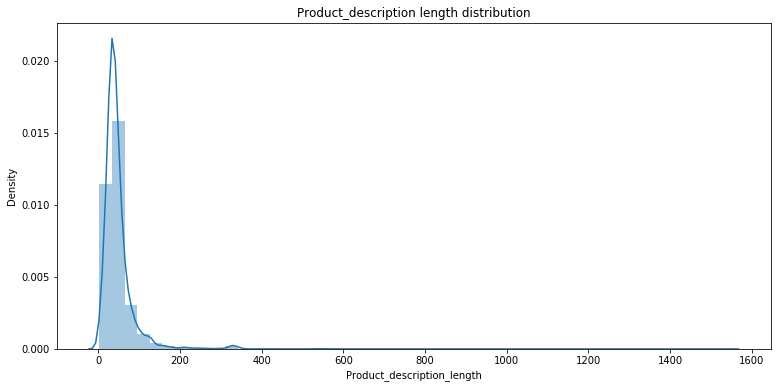

In [21]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['Product_description_length']).set_title('Product_description length distribution');

In [22]:
df['Product_description_length'].describe()

count    8000.000000
mean       48.753125
std        50.666686
min         3.000000
25%        29.000000
50%        39.000000
75%        53.000000
max      1542.000000
Name: Product_description_length, dtype: float64

In [23]:
quantile_95 = df['Product_description_length'].quantile(0.95)
df_95 = df[df['Product_description_length'] < quantile_95]

C:\Users\Prajju\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Prajju\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Prajju\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Prajju\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Su

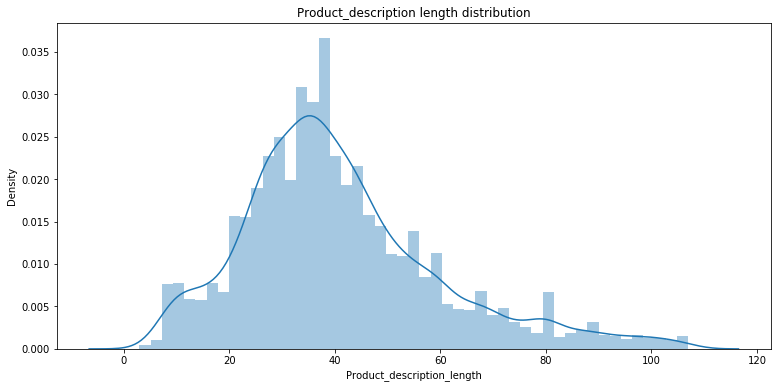

In [24]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['Product_description_length']).set_title('Product_description length distribution');

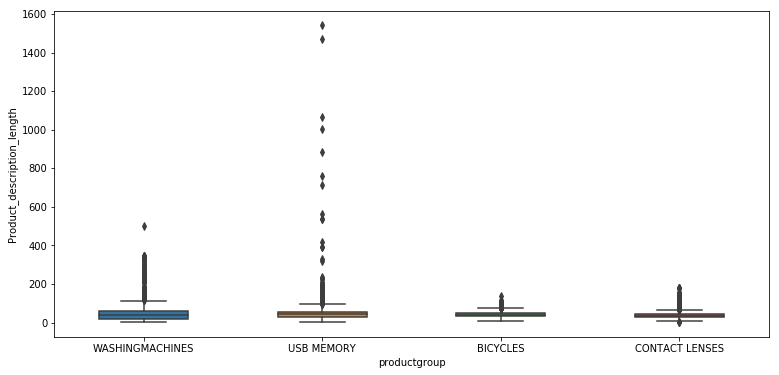

In [25]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='productgroup', y='Product_description_length', width=.5);

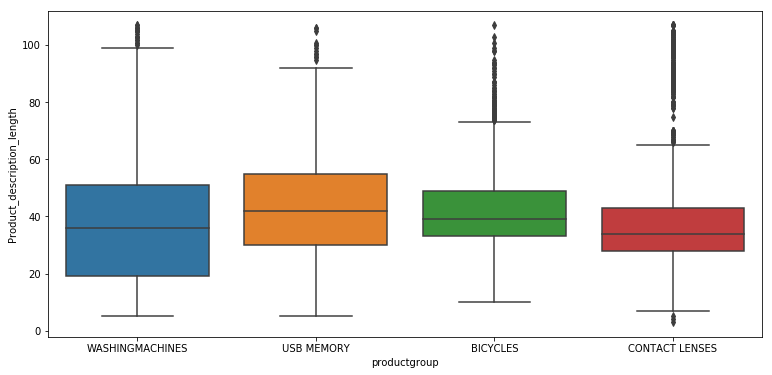

In [26]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='productgroup', y='Product_description_length');

We can see that, although the length distribution is different for every category, the difference is not too big. If we had way too different lengths between categories we would have a problem since the feature creation process may take into account counts of words. However, when creating the features with TF-IDF scoring, we will normalize the features just to avoid this.

At this point, we cannot do further Exploratory Data Analysis. We'll turn onto the Feature Engineering section.

C:\Users\Prajju\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Prajju\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Prajju\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Prajju\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Su

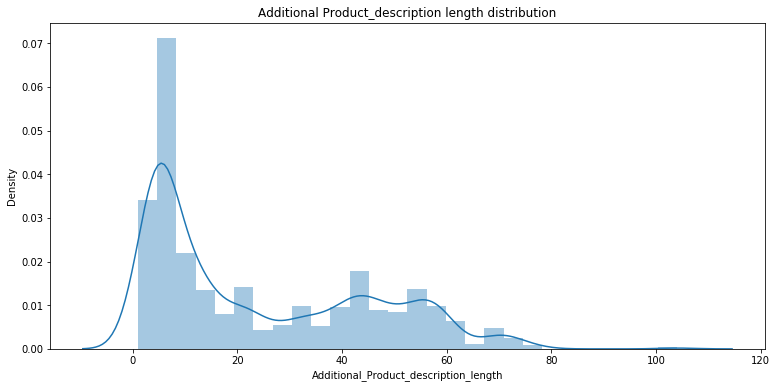

In [27]:
df['Additional_Product_description_length'] = df['add_text'].str.len()
plt.figure(figsize=(12.8,6))
sns.distplot(df['Additional_Product_description_length']).set_title('Additional Product_description length distribution');

In [28]:
quantile_95 = df['Additional_Product_description_length'].quantile(0.95)
df_95 = df[df['Additional_Product_description_length'] < quantile_95]

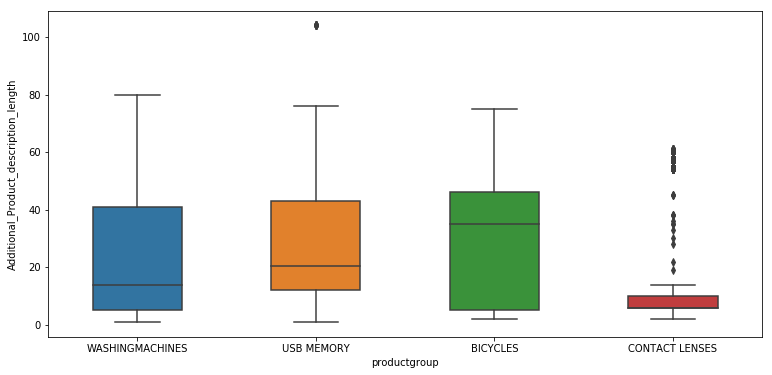

In [29]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='productgroup', y='Additional_Product_description_length', width=.5);

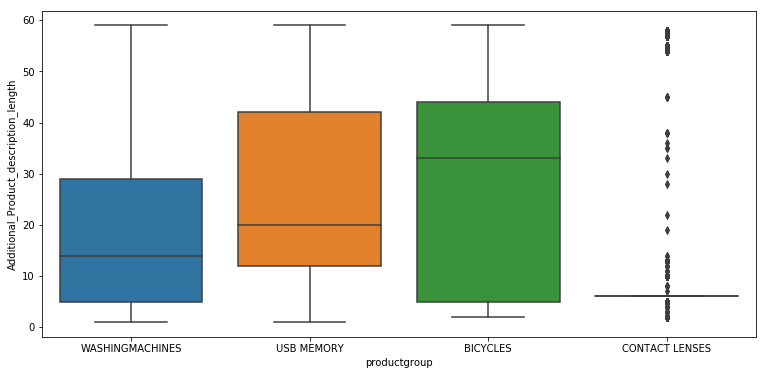

In [30]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='productgroup', y='Additional_Product_description_length');

We can see that, the length distribution is different for every category,
the difference is not too big for thre classes but for one it's very huge. 
If we had way too different lengths between categories we would have a problem since 
the feature creation process may take into account counts of words. So what we can do is we can combine these features and 
, when creating the features with TF-IDF scoring, we will normalize the features just to avoid this.
At this point, we cannot do further Exploratory Data Analysis. We'll turn onto the Feature Engineering section.

#### Check correlation between features

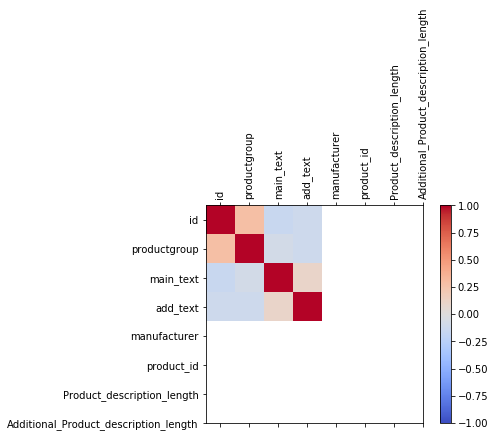

In [31]:
corr = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

In this problem, when there is no correlation between 2 variables (when correlation is 0 or near 0) the color is grey. The darkest red means there is a perfect positive correlation, while the darkest blue means there is a perfect negative correlation.

### Data preprocessing

In [32]:
#Preprocessing the data from the columns
def clean_text(s):
    """
    This function cleans the text a bit
    :param s: string
    :return: cleaned string
    """
    # split by all whitespaces
    s = s.split()
    # join tokens by single space
    # why we do this?
    # this will remove all kinds of weird space
    s = " ".join(s)
    # remove all punctuations using regex and string module
    s = re.sub(f'[{re.escape(string.punctuation)}]', ' ', s)
    # you can add more cleaning here if you want 
    # and then return the cleaned string
    return s

In [33]:
df.loc[:, "clean_main_text"] = df.main_text.apply(clean_text)
df.loc[:, "clean_add_text"] = df.add_text.apply(clean_text)

### Feature Engineering

In [34]:
# initialize LabelEncoder
lbl_enc = preprocessing.LabelEncoder()
# fit label encoder and transform values on ord_2 column
# P.S: do not use this directly. fit first, then transform
df.loc[:, "manufacturer"] = lbl_enc.fit_transform(df.manufacturer.values)

In [35]:
df.head()

,id,productgroup,main_text,add_text,manufacturer,product_id,Product_description_length,Additional_Product_description_length,clean_main_text,clean_add_text
0,26229701,WASHINGMACHINES,WAQ284E25,WASCHMASCHINEN,96,0,9,14,WAQ284E25,WASCHMASCHINEN
1,16576864,USB MEMORY,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...,PC__1100COMPUTINGMEMORY__1110MEMORYCARDS,356,1,98,40,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...,PC 1100COMPUTINGMEMORY 1110MEMORYCARDS
2,26155618,USB MEMORY,SANDISK 32GB ULTRA FIT USB 3.0,W1370,584,1,30,5,SANDISK 32GB ULTRA FIT USB 3 0,W1370
3,25646138,BICYCLES,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3-GAENGE RH 5...,FAHRRAEDER // SPORTFAHRRAEDER,495,2,70,29,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3 GAENGE RH 5...,FAHRRAEDER SPORTFAHRRAEDER
4,19764614,BICYCLES,DAHON SPEED D7 SCHWARZ ? FALTRAD,SPORTS__30000WHEELED__30070BIKES,195,2,32,32,DAHON SPEED D7 SCHWARZ FALTRAD,SPORTS 30000WHEELED 30070BIKES


In [36]:
df.loc[1]['main_text']

'LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER IPHONE, IPAD UND IPOD - MIT LIGHTNING UND USB, 128 GB'

In [37]:
#Merging the "main_text" and "add_text" since some times the "main_text" doesn't have any valid description
df['new_feature'] = df.clean_main_text.astype(str) + " " + df.clean_add_text.astype(str)

In [38]:
df.head()

,id,productgroup,main_text,add_text,manufacturer,product_id,Product_description_length,Additional_Product_description_length,clean_main_text,clean_add_text,new_feature
0,26229701,WASHINGMACHINES,WAQ284E25,WASCHMASCHINEN,96,0,9,14,WAQ284E25,WASCHMASCHINEN,WAQ284E25 WASCHMASCHINEN
1,16576864,USB MEMORY,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...,PC__1100COMPUTINGMEMORY__1110MEMORYCARDS,356,1,98,40,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...,PC 1100COMPUTINGMEMORY 1110MEMORYCARDS,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...
2,26155618,USB MEMORY,SANDISK 32GB ULTRA FIT USB 3.0,W1370,584,1,30,5,SANDISK 32GB ULTRA FIT USB 3 0,W1370,SANDISK 32GB ULTRA FIT USB 3 0 W1370
3,25646138,BICYCLES,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3-GAENGE RH 5...,FAHRRAEDER // SPORTFAHRRAEDER,495,2,70,29,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3 GAENGE RH 5...,FAHRRAEDER SPORTFAHRRAEDER,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3 GAENGE RH 5...
4,19764614,BICYCLES,DAHON SPEED D7 SCHWARZ ? FALTRAD,SPORTS__30000WHEELED__30070BIKES,195,2,32,32,DAHON SPEED D7 SCHWARZ FALTRAD,SPORTS 30000WHEELED 30070BIKES,DAHON SPEED D7 SCHWARZ FALTRAD SPORTS 30000...


In [39]:
df['main_text'][3]

'HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3-GAENGE RH 54 cm  SCHWARZ BELLEFLEUR'

In [40]:
df['add_text'][3]

'FAHRRAEDER // SPORTFAHRRAEDER'

We have to check the distribution of labels in the dataset. This is the first step when approaching a machine learning problem: We should decide the metric!


C:\Users\Prajju\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


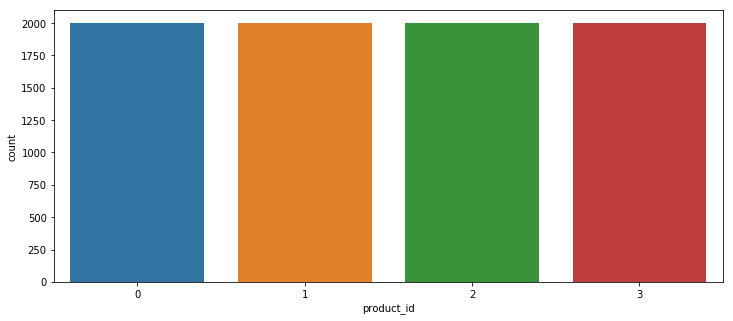

In [41]:
plt.figure(figsize=(12,5))
sns.countplot(df['product_id'])

In [42]:
df.product_id.value_counts()

0    2000
1    2000
2    2000
3    2000
Name: product_id, dtype: int64

#### As we can see that the dataset is balanced we can use ``Accuracy`` as the metrics to measure the model performance

In [43]:
#Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(df['new_feature'], df['product_id'], random_state = 0)

## Using Count vectorizer

In [44]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [45]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [46]:
test_sample = X_test.to_list()
test_sample[5]

'LEEF IBRIDGE WHITE 64GB USB 2 0 AUF LIGHTNING QUICKSHOPPING'

In [47]:
#Predict class  based on item_description using MultinomialNB
print(clf.predict(count_vect.transform(["SLIDER USB 2.0 DRIVE 16GB SLIDER USB 2.0 DRIVE 16GB 16GB, USB 2.0, 10MB/SEC"])))

[1]


In [48]:
#check Actual class as per data
df[df['main_text'] == "MERALENS A0395 GREEN WEREWOLF KONTAKTLINSEN MIT PFLEGEMITTEL MIT BEHAELTER OHNE STAERKE, 1ER PACK (1 X 2 STUECK)"]

,id,productgroup,main_text,add_text,manufacturer,product_id,Product_description_length,Additional_Product_description_length,clean_main_text,clean_add_text,new_feature
156,16292628,CONTACT LENSES,MERALENS A0395 GREEN WEREWOLF KONTAKTLINSEN MI...,HEALTH&PERSONALCARE__3100OPTICS__3104COLOUREDC...,386,3,112,58,MERALENS A0395 GREEN WEREWOLF KONTAKTLINSEN MI...,HEALTH PERSONALCARE 3100OPTICS 3104COLOUREDC...,MERALENS A0395 GREEN WEREWOLF KONTAKTLINSEN MI...


# Using TfIdF

In [49]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.new_feature).toarray()
labels = df.product_id
features.shape

(8000, 3562)

In [50]:
#Save the features for future use
# pickle.dump(tfidf.vocabulary_,open("feature.pkl","wb"))

### Check if the unigram and bigram features correlate to the class and makes sense

In [51]:
N = 2
for Product_Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product_Category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'BICYCLES':
  . Most correlated unigrams:
       . fahrraeder
       . cm
  . Most correlated bigrams:
       . fashion sport
       . sport sport
# 'CONTACT LENSES':
  . Most correlated unigrams:
       . stückunisex
       . linsen
  . Most correlated bigrams:
       . toric6 stückunisex
       . stückunisex linsen
# 'USB MEMORY':
  . Most correlated unigrams:
       . stick
       . usb
  . Most correlated bigrams:
       . usb sticks
       . usb stick
# 'WASHINGMACHINES':
  . Most correlated unigrams:
       . waschmaschinen
       . waschmaschine
  . Most correlated bigrams:
       . waschmaschinen stand
       . waschmaschine frontlader


#### As we can see that unigrams and bigrams are correlated to the product category. We will no use TfidfVectorizer to finally build several models and draw conclusion out of it

## Cross validation to determine which model works best on this dataset

In [52]:
models = [
    RandomForestClassifier(n_estimators=400, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

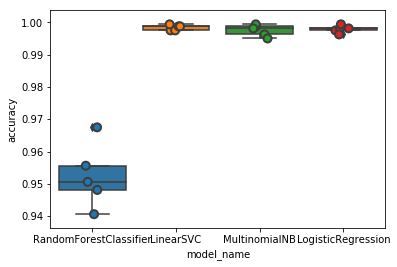

In [53]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [54]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.998375,0.000839
LogisticRegression,0.997875,0.001135
MultinomialNB,0.997500,0.001822
RandomForestClassifier,0.952500,0.009980


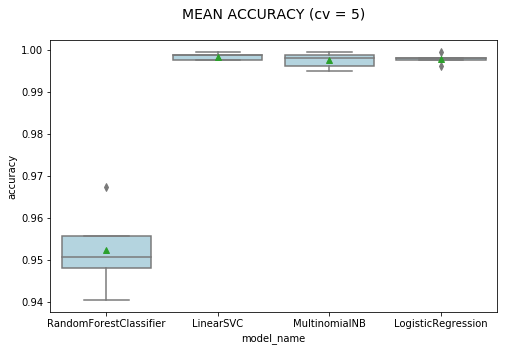

In [55]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

#### From the above result we can see most of the models performed very good and we will choose the best model here which is LinearSVC

In [56]:
#Using the best model LinearSVC
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Testing the model on a Random data from test

In [57]:
texts = ["SLIDER USB 2.0 DRIVE 16GB SLIDER USB 2.0 DRIVE 16GB 16GB, USB 2.0, 10MB/SEC"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(id_to_category[predicted]))
    print("")

"SLIDER USB 2.0 DRIVE 16GB SLIDER USB 2.0 DRIVE 16GB 16GB, USB 2.0, 10MB/SEC"
  - Predicted as: 'USB MEMORY'



In [58]:
# calculate & print accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy={accuracy}")

Accuracy=0.9977272727272727


In [59]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       684
           1       1.00      1.00      1.00       650
           2       1.00      1.00      1.00       632
           3       1.00      1.00      1.00       674

    accuracy                           1.00      2640
   macro avg       1.00      1.00      1.00      2640
weighted avg       1.00      1.00      1.00      2640



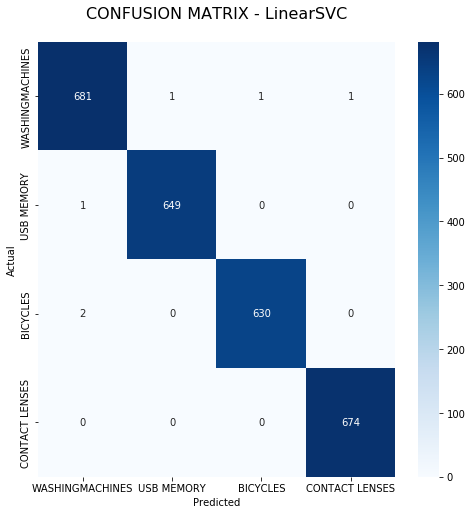

In [60]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.productgroup.values, 
            yticklabels=category_id_df.productgroup.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

#### Finally, the confusion matrix looks good (clear diagonal that represents correct classifications).